In [2]:
import numpy as np
from matplotlib import pyplot as plt
import math
from tqdm import tqdm


In [3]:
weight='weights/weights.npz'
activation='th'

В переменной weights указана путь, по которому сохраняются веса сети
В переменной activation указана функция активации, используемая сетью. Сеть может использовать одну из двух функций активации: гиперболический арксинус (asinh) и гиперболический тангенс (th)

In [4]:
class DEN:
    def __init__(self, weight=None, activation='asinh'):
        if weight is not None:
            self.activation_f = activation
            self.load_weight(weight)
    
    def train(self, input = 1, rnn = 10, output = 1, train_set = [], activation = 'asinh', ratio=0.00001, weight=weight):
        self.activation_f = activation
        self.X = np.zeros((input, 1))
        self.S = np.zeros((rnn, 1))
        self.H = np.zeros((rnn, 1))
        self.O = np.zeros((output, 1))
        self.H_prev = np.zeros_like(self.H)
        
        self.O_prev = np.zeros_like(self.O)
        
        self.Wxh = np.random.uniform(low=-0.1, high=0.1, size=(rnn, input))
        self.Whh = np.random.uniform(low=-0.1, high=0.1, size=(rnn, rnn))
        self.Who = np.random.uniform(low=-0.1, high=0.1, size=(output, rnn))
        
        self.Woh = np.random.uniform(low=-0.1, high=0.1, size=(rnn, output))
        
        self.Bh = np.random.uniform(low=-1, high=1, size=(rnn, 1))
        self.Bo = np.random.uniform(low=-1, high=1, size=(output, 1))
        
        for i in tqdm(range(len(train_set) - input - 1)):
            self.step(np.array([train_set[i:i + input]]).T)
            loss = 0.5*(train_set[i+input] - self.O[0][0])**2
            self.update_weights(self.O[0][0], train_set[i+input], ratio)
            self.H_prev = self.H
            self.O_prev = self.O
        self.save_weight(weight)
    
    def save_weight(self, weight):
        np.savez(weight, wxh=self.Wxh, whh=self.Whh ,who=self.Who, bo=self.Bo, bh=self.Bh, woh=self.Woh)
        
    def load_weight(self, weight):
        data = np.load(weight)
        self.Wxh = data['wxh']
        self.Whh = data['whh']
        self.Who = data['who']
        self.Bo  = data['bo' ]
        self.Bh  = data['bh' ]
        self.Woh = data['woh']
        
    def step(self, x_value):
        self.X = x_value
        self.S = self.Wxh @ self.X + self.Whh @ self.H_prev + self.Woh @ self.O_prev- self.Bh
        self.H = self.activation(self.S)
        self.O = self.Who @ self.H - self.Bo
        
    def activation(self, value):
        if self.activation_f == 'asinh':
            return np.arcsinh(value)
        if self.activation_f == 'th':
            return np.tanh(value)
        return np.array([])
        
    def derivative(self, value):
        if self.activation_f == 'asinh':
            return 1/(value**2 + 1)**0.5
        if self.activation_f == 'th':
            return 1 - np.tanh(value)**2
        return []
            
    def loss(self, value, expect):
        return 0.5 * (value - expect)**2
    
    def update_weights(self, value, expect, ratio=0.0001):
        self.calculate_gradient(value, expect)
        self.Wxh -= ratio * self.dL_dWxh
        self.Whh -= ratio * self.dL_dWhh
        self.Who -= ratio * self.dL_dWho
        self.Bh -= ratio * self.dL_dBh
        self.Bo -= ratio * self.dL_dBo
 # type: ignore        
        self.Woh -= ratio * self.dL_dWoh

    
    def calculate_gradient(self, value, expect):
        self.dL_dWho = (value - expect) * self.H.T
        self.dL_dWhh = (value - expect) * (self.Who.T * self.derivative(self.S)) @ self.H_prev.T
        self.dL_dBo = np.array([[-(value - expect)]])
        self.dL_dWxh = (value - expect) * (self.Who.T * self.derivative(self.S)) @ self.X.T
        self.dL_dBh = -(value - expect) * self.Who.T * self.derivative(self.S)
        
        self.dL_dWoh = (value - expect) * self.Who.T * self.derivative(self.S) @ self.O_prev.T
        
    def predict(self, test, predict_size):
        input_size = len(self.Wxh[0])
        rnn = len(self.Wxh)
        output = len(self.Who)
        
        self.X = np.zeros((input_size, 1))
        self.S = np.zeros((rnn, 1))
        self.H = np.zeros((rnn, 1))
        self.O = np.zeros((output, 1))
        self.H_prev = np.zeros_like(self.H)
        self.O_prev = np.zeros_like(self.O)
        
        predict_sequence = test[:input_size]
        
        for i in tqdm(range(len(test) - input_size + predict_size)):
            self.step(np.array([test[i:i + input_size]]).T)
            self.H_prev = self.H
            self.O_prev = self.O
            predict_sequence.append(self.O[0][0])
            if i >= len(test) - input_size: 
                test.append(self.O[0][0])
        
        return predict_sequence

X - входной слой
S - скрытый слой до активации
H - скрытый слой после активации
O - выходной слой
H_prev - контекстные нейроны, получающие значения со скрытого слоя (как у сети Элмана)
O_prev - контекстные нейроны, получающие значения с выходного слоя (как у сети Джордана)

100%|██████████| 690/690 [00:00<00:00, 58185.12it/s]


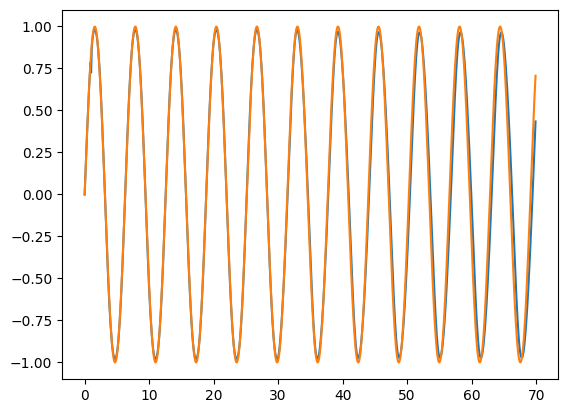

In [16]:
activation='th'
a = DEN()
a.train(10, 5, 1, [math.sin(x/10) for x in range(200000)], activation=activation, ratio=0.001)

b = DEN(weight, activation)
    
x = [(x/10) for x in range(700)]
default = [math.sin(x/10) for x in range (700)]
predict = a.predict(default[:300], 400)

plt.plot(x, predict)
plt.plot(x, default)
plt.show()

100%|██████████| 690/690 [00:00<00:00, 54590.67it/s]


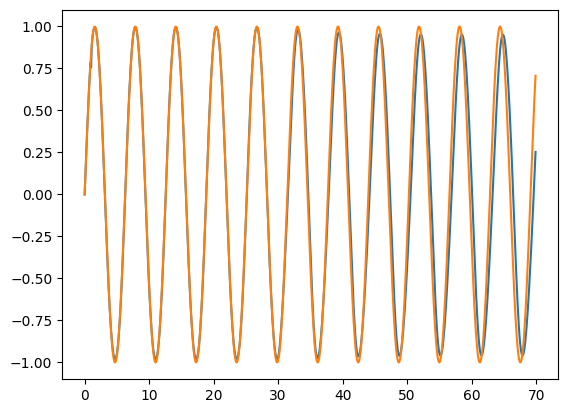

In [17]:
activation='asinh'
a = DEN()
a.train(10, 5, 1, [math.sin(x/10) for x in range(200000)], activation=activation, ratio=0.001)

b = DEN(weight, activation)
    
x = [(x/10) for x in range(700)]
default = [math.sin(x/10) for x in range (700)]
predict = a.predict(default[:300], 400)

plt.plot(x, predict)
plt.plot(x, default)
plt.show()

На простых последовательностях, вроде синуса, разные функции активации показывают примерно одинаковый результат

100%|██████████| 630/630 [00:00<00:00, 45020.13it/s]


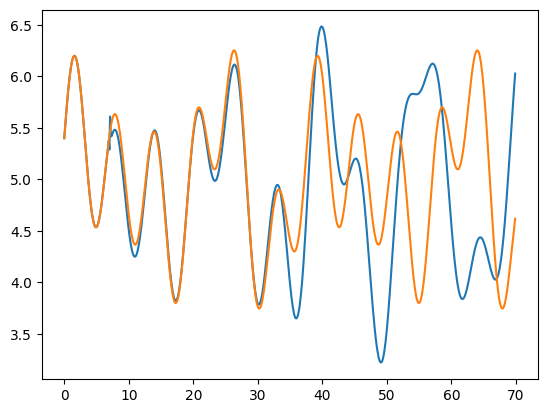

In [10]:
activation = 'asinh'
a = DEN()
a.train(70, 60, 1, [(2/3)*math.sin(x/10) + (2/5)*math.cos(x/20) + (1/2)*math.sin(x/30) + 5 for x in range(200000)], activation=activation, ratio=0.001)

b = DEN(weight, activation)
    
x = [(x/10) for x in range(700)]
default = [(2/3)*math.sin(x/10) + (2/5)*math.cos(x/20) + (1/2)*math.sin(x/30) + 5 for x in range (700)]
predict = a.predict(default[:300], 400)

plt.plot(x, predict)
plt.plot(x, default)
plt.show()

Можно заметить, что сеть сначала неплохо справляется со своей задачей, но потом её точность сильно падает
Попробуем увеличить количество нейронов входного и скрытого слоёв

100%|██████████| 500/500 [00:00<00:00, 7227.82it/s]


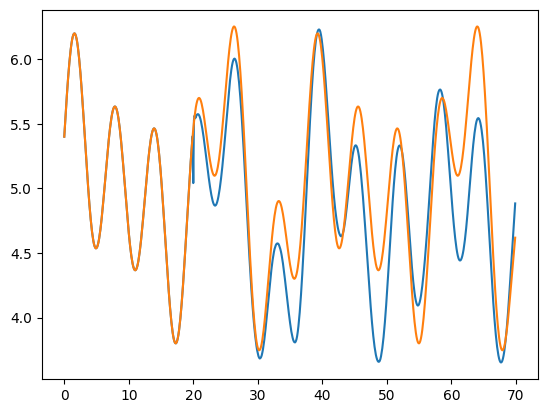

In [11]:
activation = 'asinh'
a = DEN()
a.train(200, 200, 1, [(2/3)*math.sin(x/10) + (2/5)*math.cos(x/20) + (1/2)*math.sin(x/30) + 5 for x in range(200000)], activation=activation, ratio=0.001)

b = DEN(weight, activation)
    
x = [(x/10) for x in range(700)]
default = [(2/3)*math.sin(x/10) + (2/5)*math.cos(x/20) + (1/2)*math.sin(x/30) + 5 for x in range (700)]
predict = a.predict(default[:300], 400)

plt.plot(x, predict)
plt.plot(x, default)
plt.show()

Видим, что предсказание сети уже больше похоже на то, что должно быть. Сменим функцию активации

100%|██████████| 500/500 [00:00<00:00, 4234.99it/s]


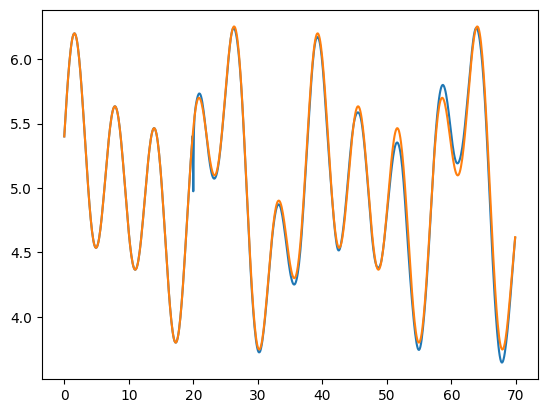

In [14]:
activation = 'th'
a = DEN()
a.train(200, 200, 1, [(2/3)*math.sin(x/10) + (2/5)*math.cos(x/20) + (1/2)*math.sin(x/30) + 5 for x in range(200000)], activation=activation, ratio=0.001)

b = DEN(weight, activation)
    
x = [(x/10) for x in range(700)]
default = [(2/3)*math.sin(x/10) + (2/5)*math.cos(x/20) + (1/2)*math.sin(x/30) + 5 for x in range (700)]
predict = a.predict(default[:300], 400)

plt.plot(x, predict)
plt.plot(x, default)
plt.show()

Успех! Сменив функцию активацию на гиперболический тангенс, получилось очень точно предсказать данную функцию